In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Burgers' equation 

We want to solve the non-linear equation:

$\displaystyle\frac{\partial u}{\partial t} + u \displaystyle\frac{\partial u}{\partial x}=0$,

To solve this equation, we will first perform a first-order upwind scheme which is explicit and first order in time. Upwind simply means that information propagates in the direction of the wind. Because we will assume $u>0$, this means that to calculate derivatives, our information has to come from the "negative" side, i.e. 

$\displaystyle\frac{\partial \phi}{\partial x} = \displaystyle\frac{\phi_{i}-\phi_{i-1}}{\Delta x}$

However, unlike linear advection (see HW6-Q2 and Q3), we have a choice on how we write the equation. 

In the linear advection equation, because $u$ was essentially constant, writing $u\partial_x a$ was the same as writing $\partial_x(ua)$. However, now we can choose whether two write the flux term as it appears in the equations $u(\partial_x u)$, or in conservative form with everything inside the flux/derivative, i.e. $\partial_x (\frac{1}{2}u^2)$.

The first form is inherently non-conservative, because the updates performed are non-conservative. Looking at the discrete equation:

$$\frac{u_{i}^{n+1} - u_i^n}{\Delta t} = - \frac{u_i^n (u_i^n - u_{i-1}^n)}{\Delta x}$$

the $x_i$ point "gives" $u_i^2/\Delta x$ to the right, while the $x_{i+1}$ point recieves $u_{i+1}u_i/\Delta x$ from the left. There is an overall loss of $(u_{i+1}-u_i)u_i/\Delta x$ in momentum across each cell boundary. We have turned a *conservative* term into a discrete non-conservative term. The term only becomes conservative as $\Delta x\to 0$ and $u_{i+1}=u_i$.

A proper conservative discretization, where we calculate the partial derivative on $\partial_x (\frac{1}{2} u^2)$, makes sure that even when $u_{i+1}\ne u_i$, the flux of momentum is still conserved in the *discrete* sense. So if $x_i$ passes/gives $\frac{1}{2}u_i^2$ of momentum, $x_{i+1}$ recieves $\frac{1}{2}u_i^2$ and not something else.

The equation reads: 

$$\frac{u^{n+1}_i - u^n_i}{\Delta t} =  -\frac{1}{2} \frac{(u^n_i)^2 - (u^n_{i-1})^2}{\Delta x}$$

Let us compare both methods using the initial conditions:

$$\renewcommand{\arraystretch}{1.75}
u(x, t=0) = \left \{ \begin{array}{cc}
    2   & x < 1/2 \\
    1   & x > 1/2
\end{array}
\right .
\renewcommand{\arraystretch}{1.0}$$


### Code

We write down routines to create the grid, set the boundary conditions and initialize the state separately

In [3]:
def create_grid(n,dx):
    return np.arange(n)*dx

In [4]:
def set_periodic_bc(mm):
    mm[0]=mm[-1]
    return mm

In [5]:
def initialize_state(n,dx):
    m=np.ones(n)
    il=int(.5/dx)
    m[:il]=2.
    return m

In [6]:
def calculate_timestep(C,u,dx):
    return np.min(dx*C/np.abs(u))

## Main loop, non-conservative solver

This is the main loop, which solves the equation using the non conservative discretization. We will run the equation between $t_0=0$ and $t_\max=0.3$. We will set periodic boundary conditions at $x=0$ and $x=1$. 

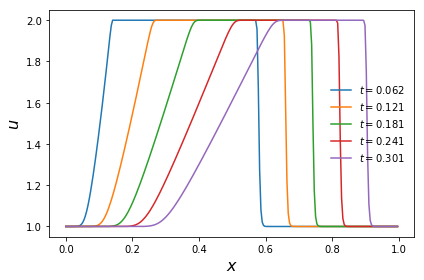

In [7]:
t0=0.; tmax=0.3;
nx=256; u=1;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
u0=initialize_state(nx+1,dx)
u0=set_periodic_bc(u0)
C=.9
t=t0
u=u0.copy()
tplot=0.06
while t < tmax:
    dt=calculate_timestep(C,u,dx)
    u[1:]=u[1:]-dt/dx*u[1:]*(u[1:]-u[:-1])
    u=set_periodic_bc(u)
    t += dt
    if(np.remainder(t,tplot) < dt):
        plt.plot(x[:nx], u[:nx], label="$t = %5.3f$" % (t))
            

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$u$", fontsize=16)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

We will measure the speed of the shock wave by finding the point where the most abrupt change happens.

In [11]:
xpos=x[np.argmin(np.diff(u))]
xini=0.5
#print 'Speed of wave:'+str((xpos-xini)/(tmax-t0))

In [12]:
xpos

0.90234375

## Main loop, conservative solver

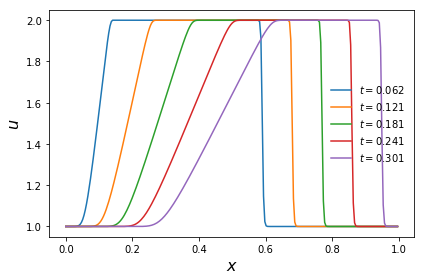

In [32]:
t0=0.; tmax=0.3;
nx=256; u=1;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
u0=initialize_state(nx+1,dx)
u0=set_periodic_bc(u0)
C=.9
t=t0
u=u0.copy()
tplot=0.06
while t < tmax:
    dt=calculate_timestep(C,u,dx)
    u[1:]=u[1:]-0.5*dt/dx*(u[1:]**2.-u[:-1]**2.)
    u=set_periodic_bc(u)
    t += dt
    if(np.remainder(t,tplot) < dt):
        plt.plot(x[:nx], u[:nx], label="$t = %5.3f$" % (t))
            

plt.xlabel("$x$", fontsize=16)
plt.ylabel("$u$", fontsize=16)
plt.legend(frameon=False, loc="best")
plt.tight_layout()
plt.show()

In [33]:
xpos=x[np.argmin(np.diff(u))]
xini=0.5
print 'Speed of wave: '+str((xpos-xini)/(tmax-t0))

Speed of wave: 1.484375


The speed of the wave is now much closer to the analytical value of 1.5. We can see how the choice of a non-conservative scheme fails to adequately capture the wave velocity.